# **Image Recognition with OpenCV**

# **Goal:** Build a simple facial recognition system using OpenCV in Python.  

## 1) Setup (Run once)

In [1]:

# If OpenCV, NumPy, or Matplotlib aren't installed in your environment, run this cell.
# You can safely re-run it; it will skip already installed packages.
try:
    import cv2, numpy, matplotlib
    print("OpenCV/NumPy/Matplotlib already available")
except Exception as e:
    !pip install -q opencv-python numpy matplotlib
    import cv2, numpy, matplotlib
    print("Installed")


✅ OpenCV/NumPy/Matplotlib already available


## 2) Imports & Helper Functions

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_bgr(img, title=None, size=(10,6)):
    """Display a BGR image (OpenCV default) correctly in Jupyter using matplotlib."""
    if img is None:
        raise ValueError("Image is None. Check your file path.")
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

def show_gray(img, title=None, size=(10,6)):
    if img is None:
        raise ValueError("Image is None. Check your file path.")
    plt.figure(figsize=size)
    plt.imshow(img, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


## 3) Face Detection (Haar Cascade)
- Works on images and is fast for a demo.
- Update `IMAGE_PATH` to your image (e.g., group photo).

Faces detected (after NMS): 14 | raw detections: 35 | profile_enabled: True | angles: [-15, 15]


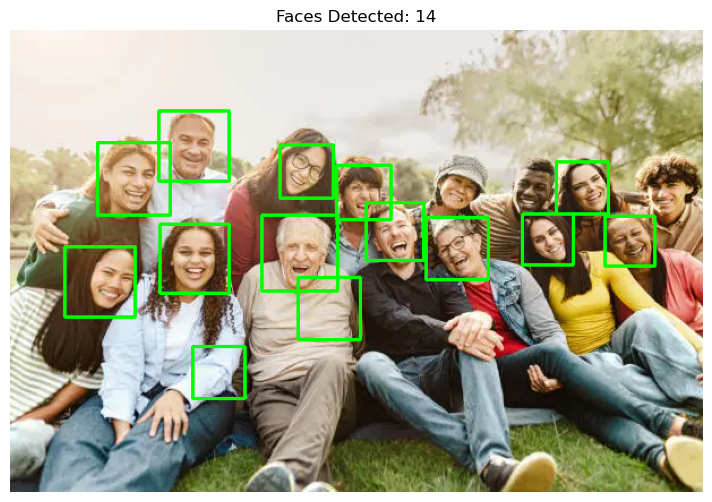

In [28]:
# === Face Detection (Haar + small-angle rotation + NMS) ===
IMAGE_PATH = r"C:\Users\suray\Desktop\1.webp"   # change to your image
SHOW_STEPS = False

import cv2, numpy as np
import math

# ---------- helpers ----------
def clahe_gray(bgr):
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(g)

def nms(boxes, overlap_thresh=0.35):
    if not boxes: return []
    boxes = np.array(boxes, dtype=float)
    x1, y1 = boxes[:,0], boxes[:,1]
    x2, y2 = boxes[:,0] + boxes[:,2], boxes[:,1] + boxes[:,3]
    areas = (x2-x1+1)*(y2-y1+1)
    order = np.argsort(y2)
    keep = []
    while len(order) > 0:
        i = order[-1]; keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[:-1]])
        yy1 = np.maximum(y1[i], y1[order[:-1]])
        xx2 = np.minimum(x2[i], x2[order[:-1]])
        yy2 = np.minimum(y2[i], y2[order[:-1]])
        w = np.maximum(0.0, xx2-xx1+1); h = np.maximum(0.0, yy2-yy1+1)
        inter = w*h
        iou = inter / (areas[i] + areas[order[:-1]] - inter)
        order = order[np.where(iou <= overlap_thresh)[0]]
    return [tuple(map(int, boxes[i])) for i in keep]

def detect(cascade, gray, scale=1.05, neighbors=4, min_size=(20,20)):
    if cascade is None or cascade.empty(): return []
    return cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=min_size)

def rotate_image(gray, angle_deg):
    h, w = gray.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    rotated = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated, M

def map_rect_back(rect, M_inv, w, h):
    # rect=(x,y,w,h) in rotated coords -> map corners back to original and make AABB
    x,y,ww,hh = rect
    pts = np.array([[x, y], [x+ww, y], [x, y+hh], [x+ww, y+hh]], dtype=np.float32)
    ones = np.ones((4,1), dtype=np.float32)
    pts_h = np.hstack([pts, ones])          # (x,y,1)
    mapped = (pts_h @ M_inv.T)              # apply inverse affine
    minx, miny = mapped[:,0].min(), mapped[:,1].min()
    maxx, maxy = mapped[:,0].max(), mapped[:,1].max()
    # clip to image bounds
    minx = max(0, minx); miny = max(0, miny)
    maxx = min(w-1, maxx); maxy = min(h-1, maxy)
    return int(minx), int(miny), int(maxx-minx), int(maxy-miny)

# ---------- load ----------
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Could not read: {IMAGE_PATH}")

gray_eq = clahe_gray(img)
H, W = gray_eq.shape[:2]

haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
prof_path = cv2.data.haarcascades + "haarcascade_profileface.xml"
haar = cv2.CascadeClassifier(haar_path)
prof = cv2.CascadeClassifier(prof_path)

if haar.empty():
    raise RuntimeError(f"Haar cascade not found at: {haar_path}")

# ---------- run detections ----------
boxes = []

# A) frontal on original (looser params → higher recall)
boxes += list(detect(haar, gray_eq, scale=1.05, neighbors=4, min_size=(20,20)))

# B) profile (left & right)
if not prof.empty():
    prof_left  = list(detect(prof, gray_eq, scale=1.05, neighbors=4, min_size=(20,20)))
    gray_flip  = cv2.flip(gray_eq, 1)
    prof_right = list(detect(prof, gray_flip, scale=1.05, neighbors=4, min_size=(20,20)))
    # map flipped boxes back
    prof_right = [(W - x - w, y, w, h) for (x,y,w,h) in prof_right]
    boxes += prof_left + prof_right

# C) small-angle rotations: detect on ±15°, then map boxes back
ANGLES = [-15, 15]
for ang in ANGLES:
    rot, M = rotate_image(gray_eq, ang)
    M_inv = cv2.invertAffineTransform(M)
    dets = list(detect(haar, rot, scale=1.05, neighbors=4, min_size=(20,20)))
    for r in dets:
        boxes.append(map_rect_back(r, M_inv, W, H))

# ---------- merge duplicates ----------
boxes_nms = nms(boxes, overlap_thresh=0.35)

# ---------- draw ----------
out = img.copy()
for (x,y,w,h) in boxes_nms:
    cv2.rectangle(out, (x,y), (x+w,y+h), (0,255,0), 2)

print(
    f"Faces detected (after NMS): {len(boxes_nms)} | "
    f"raw detections: {len(boxes)} | "
    f"profile_enabled: {not prof.empty()} | angles: {ANGLES}"
)

# optional step viz
if SHOW_STEPS:
    import matplotlib.pyplot as plt
    tmp = img.copy()
    for (x,y,w,h) in boxes: cv2.rectangle(tmp,(x,y),(x+w,y+h),(255,0,0),1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(gray_eq, cmap='gray'); plt.title("CLAHE Gray"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)); plt.title("Raw (pre-NMS)"); plt.axis('off')
    plt.show()

# show final (relies on show_bgr from earlier cell)
show_bgr(out, title=f"Faces Detected: {len(boxes_nms)}")
